In [45]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

This is the main preprocessing notebook. I will use TF-IDF to vectorise the words, using a custom tokeniser to remove stop words, small inconsietnecies in the text, as well as understanding what words are not in the english language.

In [46]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /Users/edo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [47]:
df = pd.read_csv("../data/clean_technology_reviews.csv", index_col=0)

Dropping duplicated reviews that arise through dropping metadata columns.

In [48]:
df.drop("summary", axis=1, inplace=True)

In [49]:
df.duplicated().sum()

15652

In [50]:
df = df.drop_duplicates(ignore_index=True)

In [51]:
df.head(10)

,overall,reviewText
0,5.0,Looks even better in person. Be careful to not...
1,5.0,When you don't want to spend a whole lot of ca...
2,3.0,"so the case came on time, i love the design. I..."
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,4.0,"I liked it because it was cute, but the studs ..."
5,2.0,The product looked exactly like the picture an...
6,3.0,I FINALLY got my case today. It took forever t...
7,5.0,It is a very cute case. None of the jewels hav...
8,1.0,DO NOT BUY! this item is seriously cheap as he...
9,4.0,I really love this case... you have to keep yo...


In [52]:
pd.DataFrame(np.unique(df['overall'], return_counts=True)).T.set_index(0)

,1
0,
1.0,69592.0
2.0,49156.0
3.0,80330.0
4.0,136804.0
5.0,475581.0


Adding length of reviews to each review

In [53]:
rev_len = list()
for review in df["reviewText"]:
    rev_len.append(len(str(review)))

In [54]:
df["length"] = rev_len

In [55]:
df["length"].describe()

count    811463.000000
mean        245.246403
std         385.031416
min           1.000000
25%          61.000000
50%         135.000000
75%         280.000000
max       33457.000000
Name: length, dtype: float64

In [56]:
shorter = df[df["length"]<=500].copy()


In [57]:
shorter["reviewText"].fillna("", inplace=True)

In [58]:
shorter = shorter.reset_index(drop='index')

In [59]:
shorter["binary"]= np.where(shorter['overall']>3, 1, 0)

In [60]:
shorter.head(10)

,overall,reviewText,length,binary
0,5.0,Looks even better in person. Be careful to not...,271,1
1,5.0,When you don't want to spend a whole lot of ca...,102,1
2,3.0,"so the case came on time, i love the design. I...",257,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,92,0
4,4.0,"I liked it because it was cute, but the studs ...",150,1
5,2.0,The product looked exactly like the picture an...,159,0
6,3.0,I FINALLY got my case today. It took forever t...,344,0
7,5.0,It is a very cute case. None of the jewels hav...,327,1
8,1.0,DO NOT BUY! this item is seriously cheap as he...,190,0
9,4.0,I really love this case... you have to keep yo...,188,1


In [61]:
shorter.isna().sum()

overall       0
reviewText    0
length        0
binary        0
dtype: int64

In [62]:
shorter.duplicated().sum()

0

Vectorising based on just a train split

In [63]:
X_1 = shorter["reviewText"].copy()
y_1= shorter["binary"]

# 
X_rem, X_test, y_rem, y_test = train_test_split(X_1, y_1, test_size=0.2, stratify=y_1,random_state=42)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2,stratify=y_rem, random_state=42)

In [65]:
stop_words = stopwords.words('english')

In [66]:
X_train

128787             TThe order was expeditious,and complete.
621273    Works as it should and it is pretty cool looki...
638121    I like the colors of this case and it fit my S...
641973    So far this battery has lasted longer while on...
209565    There's nothing fancy here, but it holds the p...
                                ...                        
8997      I needed to expand the SSD in my Samsung 9 ser...
170659    Works good and protects the screen as good as ...
375337    Works fine, but too small for the sweet spot o...
569891    This was a very neat product and I was satisfi...
544755                                 Ist good ,no problem
Name: reviewText, Length: 459382, dtype: object

Using a custom tokenizer, we can strip out bits of reviews that do not provide signal, like short bits of text or stop words. I use the nltk stop words

In [67]:
def my_tokenizer(document):

    # remove punctuation
    for punct in string.punctuation:
        document=document.replace(punct,'')

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # pattern denoting a sequence of at least 2 alphanumeric characters
    pattern=r"(?u)\b\w\w+\b"

        # tokenize - split by matching a pattern
    tokenized_document = re.findall(pattern, document)
    
    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]


    stemmed_tokens_list = []
    for i in tokenized_document:
        token = PorterStemmer().stem(i)
        stemmed_tokens_list.append(token)
    return stemmed_tokens_list



Fitting the vectoriser on the reviews, for now 500 features, maybe will need to address this. Also using 1 and 2 grams

In [68]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500, ngram_range=(2,2))
tfidf.fit(X_train)
X_train_transformed = tfidf.transform(X_train)
X_val_transformed = tfidf.transform(X_val)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

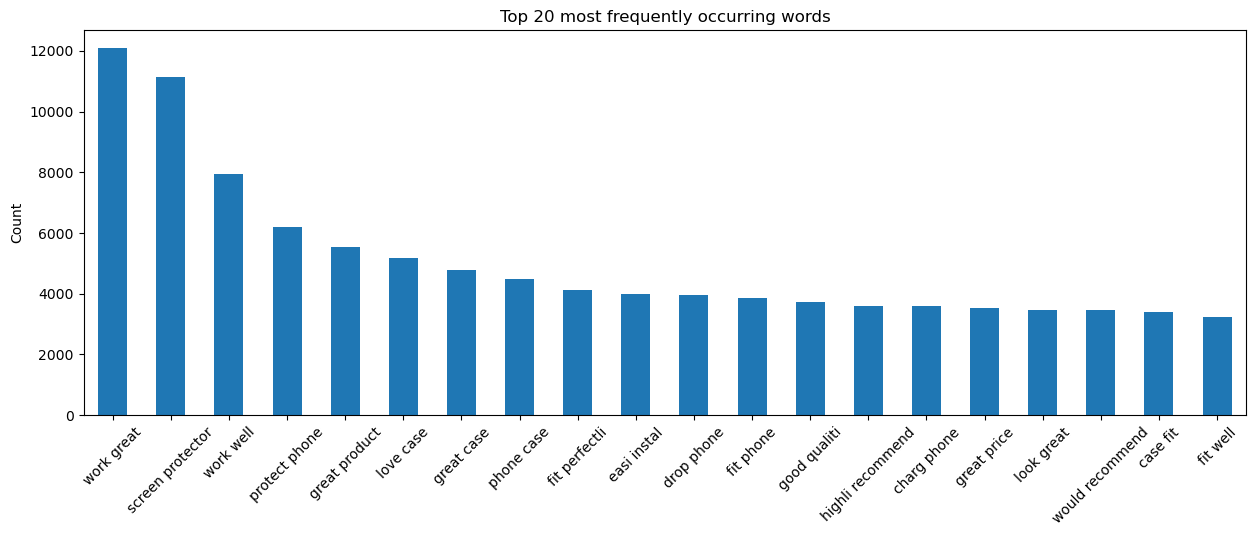

In [70]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [71]:
word_counts

,counts
work great,12076.556067
screen protector,11141.998458
work well,7938.836357
protect phone,6203.066654
great product,5541.924879
...,...
tpu case,427.099078
good hand,425.769446
phone mani,421.739813
color case,421.057604


In [72]:
review_vectors = tfidf.transform(shorter["reviewText"].fillna(''))


In [73]:
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=tfidf.get_feature_names_out())


In [74]:
output_df = pd.concat([shorter, review_vectors_df], axis=1)

In [75]:
output_df.head(3)

,overall,reviewText,length,binary,6s plu,absolut love,add bulk,add much,air bubbl,anker product,...,worth money,worth price,would buy,would definit,would highli,would like,would purchas,would recommend,would work,year old
0,5.0,Looks even better in person. Be careful to not...,271,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,When you don't want to spend a whole lot of ca...,102,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,"so the case came on time, i love the design. I...",257,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we can pickle the full dataframe ready for modelling

In [76]:
output_df.to_pickle("../data/reviews_vector_2grams.pkl")